# Polynomial Model

This section supports material covered in the class for polynomial models. Below block of code imports required packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from smt.surrogate_models import QP
from smt.sampling_methods import LHS
import matplotlib.colors as colors

random_state = 25

We will be using following function to generate data:

$$
f(x) = (6x - 2)^2sin(12x-4) + \epsilon
$$

where

$$
\epsilon \sim \mathcal{N}(0,1) \text{ and } 0 \leq x \leq 1
$$

This will generate a noisy data around function $(6x - 2)^2sin(12x-4)$. Below block of code generates 20 noisy samples and plots it.

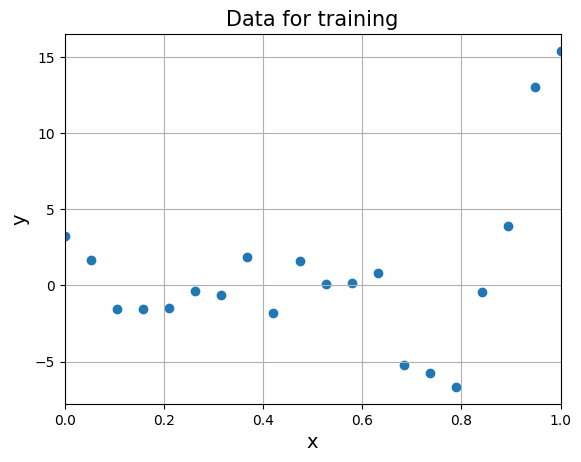

In [2]:
# Few variables
num_samples = 20
xlower = 0
xupper = 1

# Training data
x = np.linspace(xlower, xupper, num_samples)
y = (6*x - 2)**2 * np.sin(12*x - 4) + norm.rvs(size=x.shape, random_state=random_state)

# Plotting
plt.scatter(x, y)
plt.xlim((xlower, xupper))
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.title("Data for training", fontsize=15)
plt.grid()

## Fitting $2^{nd}$ order polynomial

A one variable 2nd order polynomial will be fit to above data. Later, techniques like cross-validation will be used to find order of the polynomial. Basis function vector will be:

$$
\pmb{\psi} = [1\quad x \quad x^2]^T
$$

Below block of code defines two functions - `fit_polynomial` and `predict`. First function is used to get a least square estimate for fitting a $m^{th}$ order polynomial to the given data. Second function is used for getting the prediction at given input `x` based on the parameter values. Please read comments in the code for more details.

In [4]:
def fit_polynomial(x, y, m, print_weight=True):
    """
        Function to fit a mth order polynomial to data (x,y).
        
        Parameters:
        -----------
        x : 1d numpy array
            Input training data
        y : 1d numpy array
            Output training data
        m : int
            Order of the polynomial
        print_weight : bool, optional
            An optional boolean input which controls whether to print result or not

        Returns:
        --------
        weight : 1d numpy array
            Least squares estimate of weight
    """
    
    # Initializing basis matrix of proper size
    psi = np.zeros((x.shape[0], m+1))

    # Evaluating entries in basis matrix
    for i in range(x.shape[0]):
        for j in range(m+1):
            psi[i][j] = x[i]**j

    # Psuedo inverse of basis matrix
    psi_inv = np.linalg.pinv(psi)     

    # Getting the weight
    w = np.dot(psi_inv, y)
    
    # Print the weight
    if print_weight:
        print("Weigths: {}".format(w))
    
    return w

def predict(x, w):
    """
        Function to predict at given x using the parameters.
        
        Parameters:
        -----------
        x : 1d numpy array
            Input data
        w : 1d numpy array
            Parameters of the model
        
        Returns:
        --------
        y_pred : 1d numpy array
            Predicted output
    """
    
    # Number of weigths
    m = w.shape[0]
    
    # Initializing basis matrix
    psi = np.zeros((x.shape[0], m))

    # Evaluating entries in basis matrix
    for i in range(x.shape[0]):
        for j in range(m):
            psi[i][j] = x[i]**j

    # Prediction - multiplying basis matrix with parameter
    y_pred = np.dot(psi, w)
    
    return y_pred

Below block of code fits a 2nd order polynomial to the noisy data and plots the prediction based on parameter values.

Weigths: [  4.00542894 -32.06115731  37.5344271 ]


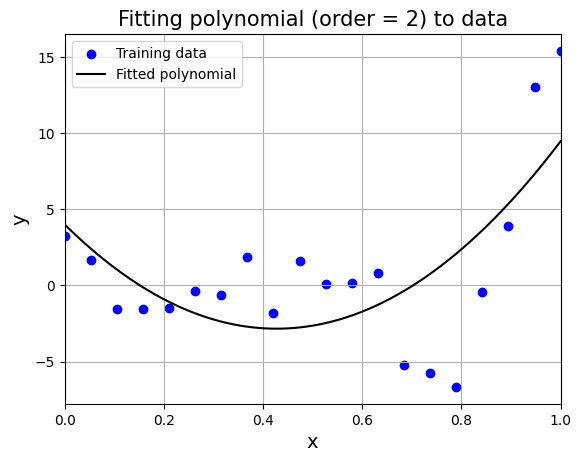

In [5]:
order = 2 # order of the polynomial

w = fit_polynomial(x, y, order) # Get the weights

x_test = np.linspace(xlower, xupper, 100) # Test input values

y_pred = predict(x_test, w) # Prediction

# Plotting the predicted values and data
plt.scatter(x, y, c="b", label="Training data")
plt.plot(x_test, y_pred, "k", label="Fitted polynomial")
plt.xlim((xlower, xupper))
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.legend()
plt.title("Fitting polynomial (order = {}) to data".format(order), fontsize=15)
plt.grid()

We can see that model is not able to capture the underlying trend in the data. We will use cross-validation to find the order of the polynomial.

## Fitting $m^{th}$ order polynomial

As explained in the lecture, cross validation is used to find the order of polynomial and avoids over-fitting the data. First, we will look into simple cross-validation and later into k-fold cross-validation. For performing simple cross-validation, data needs to be split into two parts - training and testing. To do this, `train_test_split` method from `scikit-learn` will be used. Read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn-model-selection-train-test-split) for more details. 

Below block of code splits the data into two parts, performs simple cross validation by fitting polynomial of various orders and calculates normalized RMSE. Finally, it plots the variation of NRMSE with respect to order of polynomial. Read comments in the code for more details.

Text(0.5, 1.0, 'Variation of NRMSE with order')

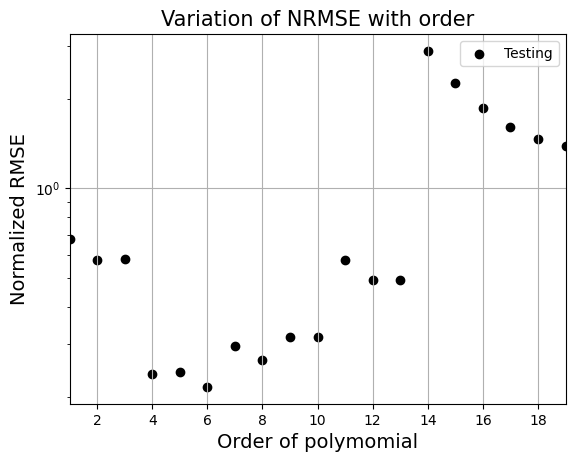

In [6]:
# Creating 1d numpy array which contains orders
orders = np.arange(1, 20,  dtype=int)

# Spliting the data into two parts
# Data is split into 75% training and 25% testing
# Note: random_state fixes the seed, so the results are same everytime
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=random_state)

# Initializing normalized RMSE list
test_metric = []

for order in orders:
    
    # Fit a particular order of polynomial
    w = fit_polynomial(x_train, y_train, order, print_weight=False)
    
    # Get the prediction at training nad testing points
    y_test_pred = predict(x_test, w)

    # Calculate normalized rmse for training and testing prediction
    test_nrmse = np.sqrt(mean_squared_error(y_test, y_test_pred)) / np.ptp(y_test)
    
    test_metric.append(test_nrmse)

# Plotting the NRMSE
plt.scatter(orders, np.array(test_metric), c="k", label="Testing")
plt.xlim((orders[0], orders[-1]))
plt.xlabel("Order of polymomial", fontsize=14)
plt.ylabel("Normalized RMSE", fontsize=14)
plt.yscale("log")
plt.legend()
plt.grid()
plt.title("Variation of NRMSE with order".format(order), fontsize=15)

From the above graph, order = 6 gives the least nrmse. Below block of code fits polynomial of order 6 to data and plots it. Feel free to change the order and see what happens to the fit.

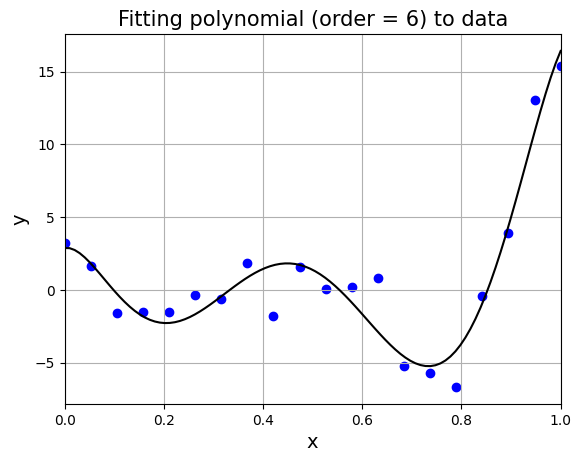

In [8]:
order = 6 # order of the polynomial

w = fit_polynomial(x, y, order, print_weight=False) # Get the wieghts

x_test = np.linspace(xlower, xupper, 100) # Test input values

y_pred = predict(x_test, w) # Prediction

# Plotting the predicted values and data
plt.scatter(x, y, c="b")
plt.plot(x_test, y_pred, "k")
plt.xlim((xlower, xupper))
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.title("Fitting polynomial (order = {}) to data".format(order), fontsize=15)
plt.grid()

To implement **K-fold cross validation**, dataset needs to be split into k smaller sets. `KFold` method within `scikit-learn` will be used to split the dataset. Read [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn-model-selection-kfold) for more information. Below block of code performs 5-fold cross validation to find the order of polynomial. Read comments in the code for more details.

Text(0.5, 1.0, 'Variation of NRMSE with order')

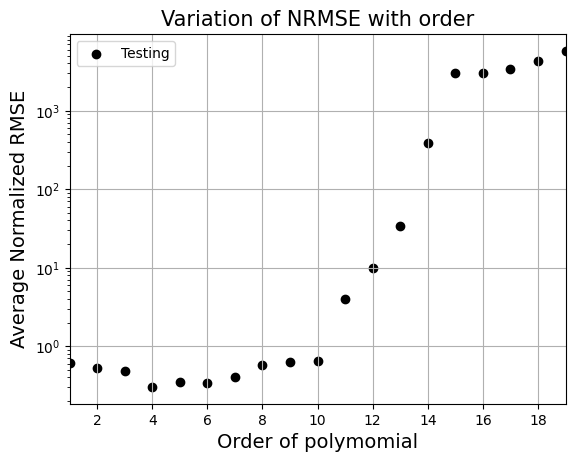

In [10]:
# Creating 1d numpy array which contains orders
orders = np.arange(1, 20,  dtype=int)

# number of folds
n_splits = 5

# Initializing normalized RMSE list
test_metric = []

# Initializing the K Fold object
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Fitting various polynomials
for order in orders:
    
    # Setting starting value of nrmse
    nrmse = 0
    
    # Fitting the polynomial of a particular order to each fold
    # and computing nrmse of the fit
    for (train_index, test_index) in kf.split(x):
        
        # Getting training data
        x_train = x[train_index]
        y_train = y[train_index]
        
        # Getting testing data
        x_test = x[test_index]
        y_test = y[test_index]

        # Fit a particular order of polynomial
        w = fit_polynomial(x_train, y_train, order, print_weight=False)

        # Get the prediction at training nad testing points
        y_test_pred = predict(x_test, w)
        
        # Adding all the nrmse to calculate average later
        nrmse = nrmse + np.sqrt(mean_squared_error(y_test, y_test_pred)) / np.ptp(y_test)
        
    # Calculating average nrmse
    test_metric.append(nrmse/n_splits)
        
# Plotting the NRMSE
plt.scatter(orders, np.array(test_metric), c="k", label="Testing")
plt.xlim((orders[0], orders[-1]))
plt.xlabel("Order of polymomial", fontsize=14)
plt.ylabel("Average Normalized RMSE", fontsize=14)
plt.yscale("log")
plt.legend()
plt.grid()
plt.title("Variation of NRMSE with order".format(order), fontsize=15)

From the above graph, order = 4 gives least nrmse. Below block of code fits polynomial of order 4 to data and plots it. Feel free to change the order and see what happens to the fit.

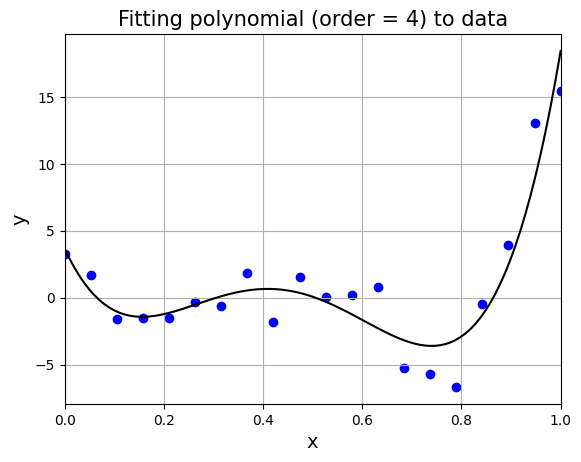

In [11]:
order = 4 # order of the polynomial

w = fit_polynomial(x, y, order, print_weight=False) # Get the weight

x_test = np.linspace(xlower, xupper, 100) # Test input values

y_pred = predict(x_test, w) # Prediction

# Plotting the predicted values and data
plt.scatter(x, y, c="b")
plt.plot(x_test, y_pred, "k")
plt.xlim((xlower, xupper))
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.title("Fitting polynomial (order = {}) to data".format(order), fontsize=15)
plt.grid()

## General 2nd order Polynomial

As explained in the lecture, general 2nd order polynomial consists of linear terms, mixed terms and 2nd order terms in the basis set.

$$
\text{Basis set: } \{ 1, x_1, x_2, ..., x_m, x_1x_2, ..., x_{m-1}x_m, x_1^2, x_2^2, ..., x_m^2 \}
$$

where $m$ is the number of dimensions (or equal to the number of columns in your training data). Fitting a 2nd order polynomial will be demonstrated using rosenbrock function, given by:

$$
    f(x_1,x_2) = (1-x_1)^2 + 100(x_2-x_1^2)^2
$$

Since there are only two variables, following will be the basis function vector:

$$
\pmb{\psi} =  [1 \quad x_1 \quad x_2 \quad x_1x_2 \quad x_1^2 \quad x_2^2 ]^T
$$

> __*NOTE*__: There is no cross-validation here since basis function vector is fixed.

`smt` provides implementation for fitting a [general 2nd order polynomial](https://smt.readthedocs.io/en/latest/_src_docs/surrogate_models/qp.html). Below block of code defines rosenbrock function and generates training data.

In [20]:
def rosenbrock(x):
    """      
        Parameters:
        -----------
        x : 1d numpy array
            Input data
            
        Returns:
        --------
        y : 1d numpy array
            Output data
    """
    
    innersum = np.zeros((x.shape[0], x.shape[1]-1))

    innersum = 100*(x[:,1:] - x[:,:-1]**2)**2 + (x[:,:-1] - 1)**2

    y = np.sum(innersum, axis=1, keepdims=True)
    
    return y

# Generate training data
sampler = LHS(xlimits=np.array([[-2, 2], [-1, 3]]), criterion="ese", random_state=random_state)
num_samples = 20
xt = sampler(num_samples)
yt = rosenbrock(xt).reshape(-1,1)

Below block of code fits a 2nd order polynomial to the data and plots the prediction.

Weights: [-0.77207299  0.20271153 -0.05337553  0.36981385  0.42940308 -0.16516883]

Normalized RMSE for the fit: 0.20290832418225072


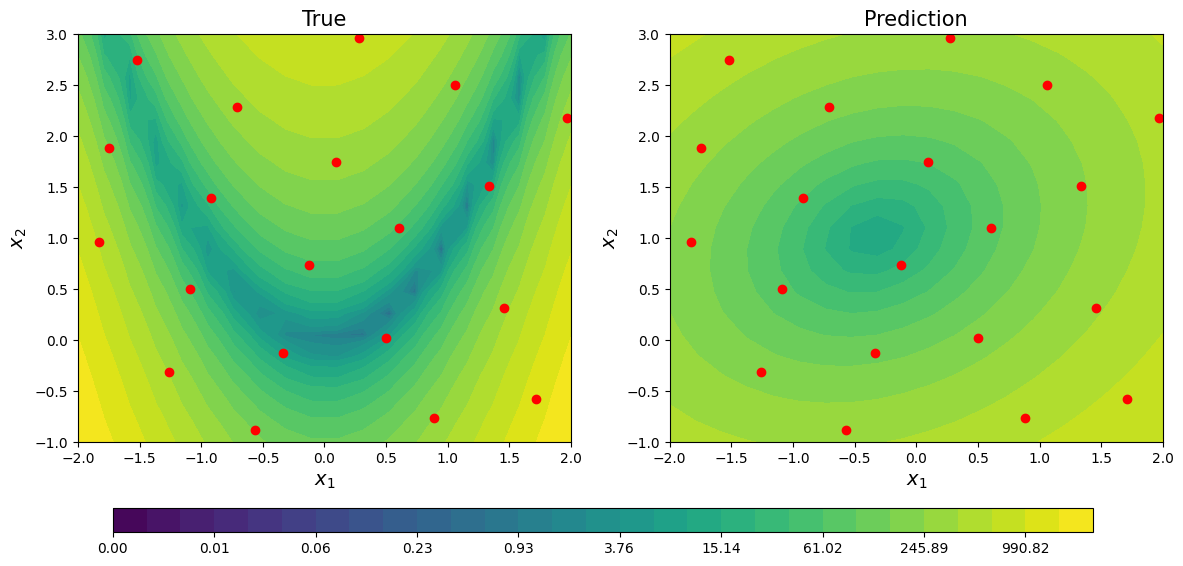

In [24]:
# Initialize the class
sm = QP(print_global=False)

# Set the training values
sm.set_training_values(xt, yt)

# Fit the training data
sm.train()

print("Weights: {}\n".format(sm.coef[:,0]))

# Predict values
yt_pred = sm.predict_values(xt)

print("Normalized RMSE for the fit: {}".format( np.sqrt(mean_squared_error(yt, yt_pred)) / np.ptp(yt)) )

########### Plotting the fit

# input for plotting
x1 = np.linspace(-2, 2, 20)
x2 = np.linspace(-1, 3, 20)

# Creating mesh grid for contour plot
X, Y = np.meshgrid(x1, x2)

# Creating input x for prediction
x = np.hstack(( X.reshape(-1,1), Y.reshape(-1,1) ))

# Output
Z = rosenbrock(x)
Z_pred = sm.predict_values(x)

# Reshaping for contourf
Z = Z.reshape(X.shape)
Z_pred = Z_pred.reshape(X.shape)

# Contour levels are evaluated in logscale since the difference
# between minimum and maximum value of function is large.
noOfLevels = 30
levels = np.logspace(np.log10(Z.min()), np.log10(Z.max()), noOfLevels, base = 10)
norm = colors.LogNorm(vmin = Z.min(), vmax = Z.max())

# Plotting the contour
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
cm = ax[0].contourf(X, Y, Z,levels=levels, norm=norm)
ax[0].scatter(xt[:,0], xt[:,1], c='r', label="Training data")
ax[0].set_xlabel("$x_1$", fontsize=14)
ax[0].set_ylabel("$x_2$", fontsize=14)
ax[0].set_title("True", fontsize=15)

ax[1].contourf(X, Y, Z_pred,levels=levels, norm=norm)
ax[1].scatter(xt[:,0], xt[:,1], c='r', label="Training data")
ax[1].set_xlabel("$x_1$", fontsize=14)
ax[1].set_ylabel("$x_2$", fontsize=14)
ax[1].set_title("Prediction", fontsize=15)

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.04])
fig.colorbar(cm, format='%.2f', cax=cbar_ax, orientation='horizontal')

As can be in seen above plots, a general 2nd order polynomial is not able to capture the rosenbrock function since it is 4th order. If we add higher order polynomials into basis function vector, it will be able to capture the rosenbrock function.